In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import hvss_utils as hvss
import cmc_utils as cmc
import load_bhcat as bhcat

In [2]:
# path = "J_MNRAS_478_1520/table2_clean.dat"
mw_bh_path = "holger_baumgardt_clean.txt" # Source: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/parameter.html
mw_h_path = "harris2010_II_clean.txt" # Source: https://heasarc.gsfc.nasa.gov/W3Browse/all/globclust.html

In [11]:
# Load cleaned catalog data
df_mw = bhcat.load(mw_bh_path)

# Load cleaned Harris data (for metallicities)
# "cleaned" = ID renamed to Cluster, names edited to match Baumgardt & Holger, Z=-100 if there's no metallicity measurement (these clusters are also the ones with wt=0 i.e. no stellar metallicities have been measured)
df_mw_h = bhcat.load(mw_h_path)
# drop rows with [Fe/H]=-100
df_mw_h = df_mw_h[df_mw_h["[Fe/H]"] != -100.0]

# Merge the two datasets
# df_mw = df_mw.merge(df_mw_h, how="inner", on="Cluster")
df_mw = pd.merge(df_mw, df_mw_h, how="inner", on="Cluster")
del df_mw_h

In [10]:
### Calculate some things

# Calculate radius ratios
df_mw["rc/rh,l"] = df_mw["rc"] / df_mw["rh,l"]
df_mw["rc/rh,m"] = df_mw["rc"] / df_mw["rh,m"]
df_mw["logMass"] = np.log10(df_mw["Mass"])

print(df_mw.columns)
df_mw

Index(['Cluster', 'RA', 'DEC', 'R_Sun', 'DR', 'R_GC', 'DR.1', 'N_RV', 'N_PM',
       'Mass', 'DM', 'V', 'DV', 'M/L_V', 'DM/L', 'rc', 'rh,l', 'rh,m', 'rt',
       'rho_c', 'rho_h,m', 'sig_c', 'sig_h,m', 'lgTrh', 'MF', 'F_REM', 'sig0',
       'vesc', 'etac', 'etah', '[Fe/H]', 'wt', 'E(B-V)', 'V_HB', '(m-M)V',
       'V_t', 'M_V,t', 'U-B', 'B-V', 'V-R', 'V-I', 'spt', 'ellip', 'rc/rh,l',
       'rc/rh,m', 'logMass'],
      dtype='object')


,Cluster,RA,DEC,R_Sun,DR,R_GC,DR.1,N_RV,N_PM,Mass,...,"M_V,t",U-B,B-V,V-R,V-I,spt,ellip,"rc/rh,l","rc/rh,m",logMass
0,NGC_104,6.02379,-72.08131,4.52,0.03,7.52,0.01,4379.0,18199.0,895000.0,...,-9.42,0.37,0.88,0.53,1.14,G4,0.09,0.217033,0.125397,5.951823
1,NGC_288,13.18850,-26.58261,8.99,0.09,12.21,0.06,567.0,3271.0,93400.0,...,-6.75,0.08,0.65,0.45,0.94,NaN,NaN,0.615780,0.428913,4.970347
2,NGC_362,15.80942,-70.84878,8.83,0.10,9.62,0.06,509.0,10969.0,284000.0,...,-8.43,0.16,0.77,0.49,1.01,F9,0.01,0.182648,0.105541,5.453318
3,Whiting_1,30.73750,-3.25278,30.59,1.17,35.15,1.11,7.0,0.0,1970.0,...,-2.46,NaN,NaN,NaN,NaN,NaN,NaN,0.257895,0.158167,3.294466
4,NGC_1261,48.06754,-55.21622,16.40,0.19,18.28,0.17,300.0,154.0,182000.0,...,-7.80,0.13,0.72,0.45,0.93,F7,0.07,0.270769,0.168260,5.260071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,Pal_13,346.68519,12.77154,23.48,0.40,24.57,0.36,20.0,0.0,3020.0,...,-3.76,-0.11,0.76,NaN,NaN,NaN,NaN,0.153188,0.116224,3.480007
160,NGC_7492,347.11117,-15.61147,24.39,0.57,23.57,0.52,29.0,0.0,26600.0,...,-5.81,0.23,0.42,0.24,NaN,NaN,NaN,0.621693,0.475228,4.424882
161,BH_176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,Terzan_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
### Combine Catalog_models.dat and dyn.dat to label 

# Load CMC catalog
catalog_models = pd.read_csv(
    "Catalog_models.dat",
    names=["Index", "N", "rv", "rg", "Z", "N_BH", "status"],
    skiprows=2,
    delimiter=" ",
)
catalog_models.drop(columns="Index", inplace=True)

# Load final dyn_dat info for timestep
clip = 148
df_cmc = []
for mi, model in catalog_models.iterrows():
    if mi > clip-1:
        continue
    
    cmc_cluster = (
        "N{}_".format(hvss.ns_to_str(model["N"] * 100000))
        + "rv{:n}_".format(model["rv"])
        + "rg{:n}_".format(model["rg"])
        + "Z{}".format(model["Z"])
    )
    print("{} ({}/{})...".format(cmc_cluster, mi+1, len(catalog_models)))

    # Read saved data file
    path = "/hildafs/projects/phy200025p/share/catalog_files/{}.tar.gz/initial.dyn.dat".format(cmc_cluster)
#     try:
#         df_dd = cmc.load_dyn_dat(
#             path,
#         )
#     except:
#         # Look for "v2" cluster instead; if this doesn't work, let it fail
#         path = path.replace("rv", "v2_rv")
#         df_dd = cmc.load_dyn_dat(
#             path,
#         )
        
#     df_dd.drop(
#         index=range(df_dd.shape[0]-1),
#         inplace=True,
#     )

    # This counts the number of lines in the file, so we can choose to load the last one and not run out of RAM
    line = 0
    chksz = 10000
    try:
        for chunk in pd.read_csv(
            path,
            chunksize=chksz,
            index_col=0,
            usecols=[0],
        ):
            line += chunk.shape[0]
    except:
        path = path.replace("rv", "v2_rv")
        for chunk in pd.read_csv(
            path,
            chunksize=chksz,
            index_col=0,
            usecols=[0],
        ):
            line += chunk.shape[0]

    # Read the second line to get headers
    with open(path) as file:
        for li, l in enumerate(file):
            if li == 1:
                cols = l
                break

    # Process columns, stripping numbers
    # "." split is necessary because of inconsistency in headers
    # "\n" strip applied to last label
    cols = [s.split(":")[-1].split(".")[-1] for s in cols.split(" ")]
    cols[-1] = cols[-1].strip("\n")

    # Load data
    df_dd = pd.read_csv(
        path,
        names=cols,
        delimiter=" ",
        skiprows=line,
    )
    
    # Convert units
    units = cmc.get_unitdict(path.replace("dyn.dat", "conv.sh"))
    df_dd["t"] *= units["myr"]
    df_dd["M"] *= units["msun"]
    df_dd["rc_spitzer"] *= units["pc"]
    df_dd["r_h"] *= units["pc"]
    
    df_cmc.append(df_dd)
    
# Append dyn_dat info to catalog_models to make df_cmc
df_cmc = pd.concat(df_cmc)
df_cmc.reset_index(drop=True, inplace=True)
df_cmc = pd.concat((catalog_models.iloc[:clip, :], df_cmc), axis=1)
print(df_cmc.columns)

# Save the dataframe for quick loading later
df_cmc.to_csv("cmc-catalog.final_dyn.dat", index=False)

N2e5_rv0.5_rg2_Z0.0002 (1/148)...
N4e5_rv0.5_rg2_Z0.0002 (2/148)...
N8e5_rv0.5_rg2_Z0.0002 (3/148)...
N1.6e6_rv0.5_rg2_Z0.0002 (4/148)...
N2e5_rv0.5_rg2_Z0.002 (5/148)...
N4e5_rv0.5_rg2_Z0.002 (6/148)...
N8e5_rv0.5_rg2_Z0.002 (7/148)...
N1.6e6_rv0.5_rg2_Z0.002 (8/148)...
N2e5_rv0.5_rg2_Z0.02 (9/148)...
N4e5_rv0.5_rg2_Z0.02 (10/148)...
N8e5_rv0.5_rg2_Z0.02 (11/148)...
N1.6e6_rv0.5_rg2_Z0.02 (12/148)...
N2e5_rv0.5_rg8_Z0.0002 (13/148)...
N4e5_rv0.5_rg8_Z0.0002 (14/148)...
N8e5_rv0.5_rg8_Z0.0002 (15/148)...
N1.6e6_rv0.5_rg8_Z0.0002 (16/148)...
N2e5_rv0.5_rg8_Z0.002 (17/148)...
N4e5_rv0.5_rg8_Z0.002 (18/148)...
N8e5_rv0.5_rg8_Z0.002 (19/148)...
N1.6e6_rv0.5_rg8_Z0.002 (20/148)...
N2e5_rv0.5_rg8_Z0.02 (21/148)...
N4e5_rv0.5_rg8_Z0.02 (22/148)...
N8e5_rv0.5_rg8_Z0.02 (23/148)...
N1.6e6_rv0.5_rg8_Z0.02 (24/148)...
N2e5_rv0.5_rg20_Z0.0002 (25/148)...
N4e5_rv0.5_rg20_Z0.0002 (26/148)...
N8e5_rv0.5_rg20_Z0.0002 (27/148)...
N1.6e6_rv0.5_rg20_Z0.0002 (28/148)...
N2e5_rv0.5_rg20_Z0.002 (29/148)...


In [6]:
### Add a column for the binsingle ejection counts
df_cmc = pd.read_csv("cmc-catalog.final_dyn.dat")

df_cmc["N_ej"] = np.zeros(df_cmc.shape[0])
for ri, row in df_cmc.iterrows():
    cmc_cluster = "_".join((
        "N{}".format(hvss.ns_to_str(row["N"] * 100000)),
        "rv{:n}".format(row["rv"]),
        "rg{:n}".format(row["rg"]),
        "Z{}".format(row["Z"]),
    ))
    path = "data/%s/output_N-10_ejections.txt" % cmc_cluster
    with open(path) as file:
        for count, line in enumerate(file):
            pass
    df_cmc.loc[ri, "N_ej"] = (count) / 10
    print(cmc_cluster, (count)/10)

df_cmc.to_csv("cmc-catalog.final_dyn.dat", index=False)

N2e5_rv0.5_rg2_Z0.0002 5005.5
N4e5_rv0.5_rg2_Z0.0002 29063.2
N8e5_rv0.5_rg2_Z0.0002 7139.8
N1.6e6_rv0.5_rg2_Z0.0002 0.0
N2e5_rv0.5_rg2_Z0.002 1161.6
N4e5_rv0.5_rg2_Z0.002 2170.0
N8e5_rv0.5_rg2_Z0.002 2699.0
N1.6e6_rv0.5_rg2_Z0.002 2005.9
N2e5_rv0.5_rg2_Z0.02 1359.0
N4e5_rv0.5_rg2_Z0.02 1101.9
N8e5_rv0.5_rg2_Z0.02 1967.5
N1.6e6_rv0.5_rg2_Z0.02 2924.0
N2e5_rv0.5_rg8_Z0.0002 9550.0
N4e5_rv0.5_rg8_Z0.0002 20253.7
N8e5_rv0.5_rg8_Z0.0002 7386.4
N1.6e6_rv0.5_rg8_Z0.0002 0.0
N2e5_rv0.5_rg8_Z0.002 1404.0
N4e5_rv0.5_rg8_Z0.002 2187.1
N8e5_rv0.5_rg8_Z0.002 2145.3
N1.6e6_rv0.5_rg8_Z0.002 1766.2
N2e5_rv0.5_rg8_Z0.02 2637.4
N4e5_rv0.5_rg8_Z0.02 732.8
N8e5_rv0.5_rg8_Z0.02 1965.0
N1.6e6_rv0.5_rg8_Z0.02 2744.3
N2e5_rv0.5_rg20_Z0.0002 7988.4
N4e5_rv0.5_rg20_Z0.0002 13964.0
N8e5_rv0.5_rg20_Z0.0002 5979.4
N1.6e6_rv0.5_rg20_Z0.0002 0.0
N2e5_rv0.5_rg20_Z0.002 2045.6
N4e5_rv0.5_rg20_Z0.002 3589.4
N8e5_rv0.5_rg20_Z0.002 2189.2
N1.6e6_rv0.5_rg20_Z0.002 1911.4
N2e5_rv0.5_rg20_Z0.02 605.3
N4e5_rv0.5_rg20_Z0.02 1

In [40]:
# Load saved CMC dataframe
# Note that "N" is initial size (/1e5), and "N.1" is ending size
df_cmc = pd.read_csv("cmc-catalog.final_dyn.dat")

# Calculate the radius ratio, log of the mass, and [Fe/H] = log10(Z/Z_sun)
df_cmc["rc_spitzer/r_h"] = df_cmc["rc_spitzer"] / df_cmc["r_h"]
df_cmc["logM"] = np.log10(df_cmc["M"])
df_cmc["[Fe/H]"] = np.log10(df_cmc["Z"]/0.02)
df_cmc
# df_cmc.columns

,N,rv,rg,Z,N_BH,status,t,Dt,tcount,N.1,...,rc_spitzer,v0_rms,rc_nb,DMse(MSUN),DMrejuv(MSUN),N_c_nb,N_ej,rc_spitzer/r_h,logM,[Fe/H]
0,2.0,0.5,2.0,0.0002,0.0,dissolved,3724.023967,3.649728e-05,542622,15719,...,0.019971,0.184678,0.027821,0,0,25.665034,5005.5,0.011960,3.935542,-2.0
1,4.0,0.5,2.0,0.0002,0.0,dissolved,5127.349737,1.794744e-05,1439262,15719,...,0.018178,0.130559,0.025205,0,0,24.256658,29063.2,0.010689,3.981845,-2.0
2,8.0,0.5,2.0,0.0002,0.0,survived,13477.878869,2.862692e-05,1137814,265985,...,0.025228,0.173806,0.035740,0,0,126.338890,7139.8,0.006555,5.042128,-2.0
3,16.0,0.5,2.0,0.0002,-100.0,-100,2.485142,1.238304e-07,8267,1595386,...,0.026259,0.976180,0.073378,0,0,6471.145400,0.0,0.062721,5.985664,-2.0
4,2.0,0.5,2.0,0.0020,0.0,dissolved,4215.276317,6.371344e-05,352987,15719,...,0.033011,0.147446,0.048680,0,0,32.211470,1161.6,0.017441,3.932568,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,16.0,4.0,20.0,0.0200,791.0,survived,13999.990006,1.192075e-06,436379,1582117,...,0.517578,0.395653,0.092148,0,0,2419.311300,258.5,0.061646,5.716774,0.0
144,32.0,1.0,20.0,0.0002,852.0,survived,3129.499434,2.488791e-06,1539798,3071351,...,0.277744,0.323548,0.217088,0,0,5456.909400,1546.4,0.071735,6.056813,-2.0
145,32.0,2.0,20.0,0.0002,1714.0,survived,8350.803029,1.180068e-06,1551869,3039922,...,0.130361,0.327489,0.047158,0,0,468.720300,1559.1,0.018246,6.032030,-2.0
146,32.0,1.0,20.0,0.0200,518.0,survived,5644.221076,2.182751e-06,1643106,3147560,...,0.110580,0.352574,0.075013,0,0,2451.751100,1091.5,0.037423,6.037059,0.0


In [42]:
### Calculate nearest neighbors

def nn_in_cmc(df_cmc, df_mw, cols, translator=None):
    """
    Given a df of CMC models and a df of observed GCs, finds the nearest CMC model for each observed GC in the 2D space of the CMC headers cols.
    Note that the specified columns are expected to be normalized to the same space.
    Arguments:
        df_cmc : pd.DataFrame of parameters for CMC models
        df_mw : pd.DataFrame of parameters for observed clusters
        cols : CMC column names to use as dimensions to calculate distance in
        translator : dictionary to translate CMC column names to observation column names
    Returns:
        nnis : pd.Series of indices to df_cmc, ordered to prescribe the closest CMC model for each observed GC.
    """
    # Initialize distance array
    d = np.zeros((df_mw.shape[0],df_cmc.shape[0]))
    
    # Add squared differences
    for col in cols:
        # If there is a translator, use it
        if translator != None:
            col_mw = translator[col]
        else:
            col_mw = col
        # Add the squared distance to the df
        cx = np.array(df_cmc[col])
        mx = np.reshape(df_mw[col_mw].to_numpy(), (df_mw.shape[0],1))
        d += (cx - mx)**2
        
    # Sqrt to get distance; get array of minima
    d = np.sqrt(d)
    nnis = np.argmin(d, axis=1)
    return nnis

# Dictionary to convert headers
cmc_to_mw = {
    "logM" : "logMass",
    "rc_spitzer/r_h" : "rc/rh,m",
    "logM_norm" : "logMass_norm",
    "rc_spitzer/r_h_norm" : "rc/rh,m_norm",
    "[Fe/H]" : "[Fe/H]",
    "[Fe/H]_norm" : "[Fe/H]_norm",
}

# Data normalization, by CMC space
means = {}
stds = {}
nn_cols = [
    "logM",
    "rc_spitzer/r_h",
    "[Fe/H]",
]
for col in nn_cols:
    means[cmc_to_mw[col]] = df_cmc[col].mean()
    stds[cmc_to_mw[col]] = df_cmc[col].std()
    df_cmc["%s_norm" % col] = (df_cmc[col] - means[cmc_to_mw[col]]) / stds[cmc_to_mw[col]]
# for col in ("logMass", "rc/rh,m"):
for col in [cmc_to_mw[cn] for cn in nn_cols]:
    df_mw["%s_norm" % col] = (df_mw[col] - means[col]) / stds[col]

# Find the nearest neighbor Euclidean-wise in the normalized space
df_mw["nn_cmc"] = nn_in_cmc(
    df_cmc,
    df_mw,
    ["%s_norm" % c for c in nn_cols],
    translator=cmc_to_mw,
)

# Add column of weights to df_cmc, equal to the number of MW GCs that have the model as its nearest CMC neighbor
df_cmc["weights_mw"] = np.histogram(
    df_mw["nn_cmc"],
    bins=np.arange(-0.5,df_cmc.shape[0]+0.5),
)[0]

# Calculate the total number of ejections for the catalog!!!
N_ej = (df_cmc["weights_mw"] * df_cmc["N_ej"]).sum()
print("Expected number of ejections N_ej = %f" % N_ej)
print("N_ej/13.8Gyr = %g/Myr = 1/(%g yr)" % (N_ej/13800, 13800000000/N_ej))
df_cmc

Expected number of ejections N_ej = 262943.900000
N_ej/13.8Gyr = 19.0539/Myr = 1/(52482.7 yr)


,N,rv,rg,Z,N_BH,status,t,Dt,tcount,N.1,...,DMrejuv(MSUN),N_c_nb,N_ej,rc_spitzer/r_h,logM,[Fe/H],logM_norm,rc_spitzer/r_h_norm,[Fe/H]_norm,weights_mw
0,2.0,0.5,2.0,0.0002,0.0,dissolved,3724.023967,3.649728e-05,542622,15719,...,0,25.665034,5005.5,0.011960,3.935542,-2.0,-1.734918,-0.916445,-1.212436,0
1,4.0,0.5,2.0,0.0002,0.0,dissolved,5127.349737,1.794744e-05,1439262,15719,...,0,24.256658,29063.2,0.010689,3.981845,-2.0,-1.660702,-0.930077,-1.212436,0
2,8.0,0.5,2.0,0.0002,0.0,survived,13477.878869,2.862692e-05,1137814,265985,...,0,126.338890,7139.8,0.006555,5.042128,-2.0,0.038757,-0.974413,-1.212436,0
3,16.0,0.5,2.0,0.0002,-100.0,-100,2.485142,1.238304e-07,8267,1595386,...,0,6471.145400,0.0,0.062721,5.985664,-2.0,1.551091,-0.372090,-1.212436,0
4,2.0,0.5,2.0,0.0020,0.0,dissolved,4215.276317,6.371344e-05,352987,15719,...,0,32.211470,1161.6,0.017441,3.932568,-1.0,-1.739685,-0.857664,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,16.0,4.0,20.0,0.0200,791.0,survived,13999.990006,1.192075e-06,436379,1582117,...,0,2419.311300,258.5,0.061646,5.716774,0.0,1.120103,-0.383613,1.212436,0
144,32.0,1.0,20.0,0.0002,852.0,survived,3129.499434,2.488791e-06,1539798,3071351,...,0,5456.909400,1546.4,0.071735,6.056813,-2.0,1.665130,-0.275423,-1.212436,0
145,32.0,2.0,20.0,0.0002,1714.0,survived,8350.803029,1.180068e-06,1551869,3039922,...,0,468.720300,1559.1,0.018246,6.032030,-2.0,1.625408,-0.849033,-1.212436,1
146,32.0,1.0,20.0,0.0200,518.0,survived,5644.221076,2.182751e-06,1643106,3147560,...,0,2451.751100,1091.5,0.037423,6.037059,0.0,1.633468,-0.643385,1.212436,0


In [47]:
# Print CMC rep. for M3
df_cmc.iloc[df_mw[df_mw.Cluster=="NGC_5272"].nn_cmc]

,N,rv,rg,Z,N_BH,status,t,Dt,tcount,N.1,...,DMrejuv(MSUN),N_c_nb,N_ej,rc_spitzer/r_h,logM,[Fe/H],logM_norm,rc_spitzer/r_h_norm,[Fe/H]_norm,weights_mw
51,16.0,1.0,8.0,0.0002,183.0,survived,14000.001833,0.000014,1509746,1357141,...,0,14573.389,2418.5,0.194903,5.668116,-2.0,1.042113,1.045423,-1.212436,4


In [9]:
# Save weights with core collapse data, in new version of Catalog_models.  Note: TotalTime is time of core collapse
df_cc = pd.read_csv("cmc_core_collapsed.dat")
df_cc.sort_values(by=["N","rv","rg","Z"], inplace=True, ignore_index=True)
df_cmc.sort_values(by=["N","rv","rg","Z"], inplace=True, ignore_index=True)
df_cc["weights_mw"] = df_cmc["weights_mw"]
df_cc.rename(columns={"ccflag": "cc_flag", "TotalTime": "cc_time", "tcount": "cc_tcount"}, inplace=True)
df_cc.to_csv("Catalog_models_ccw.dat")
df_cc

,N,rv,rg,Z,cc_flag,cc_tcount,cc_time,weights_mw
0,2.0,0.5,2.0,0.0002,1,315531,299.78033,0
1,2.0,0.5,2.0,0.0020,1,201760,746.52290,0
2,2.0,0.5,2.0,0.0200,1,1244222,1625.95730,0
3,2.0,0.5,8.0,0.0002,1,588515,67.43501,0
4,2.0,0.5,8.0,0.0020,1,174079,1373.08840,1
...,...,...,...,...,...,...,...,...
143,16.0,4.0,20.0,0.0200,0,436379,13999.99000,0
144,32.0,1.0,20.0,0.0002,0,1539798,3129.49930,2
145,32.0,1.0,20.0,0.0200,0,1643106,5644.22070,1
146,32.0,2.0,20.0,0.0002,0,1551870,8350.81300,0


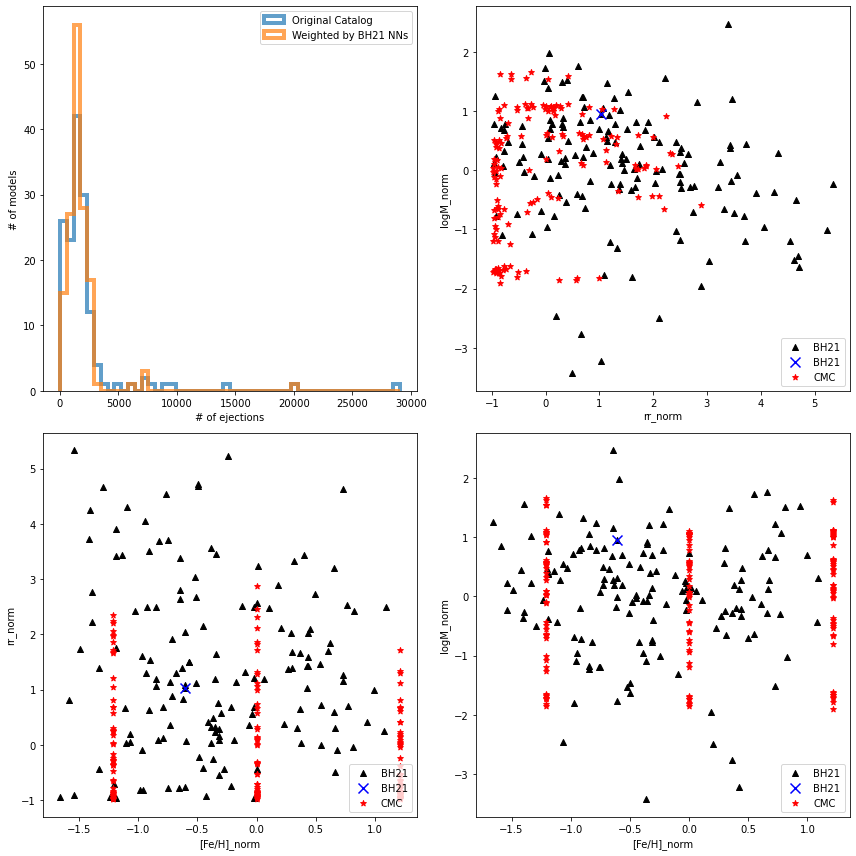

In [22]:
### Diagnostic plots
fig, axd = plt.subplot_mosaic(
    [["hist","scat_m-r"],
     ["scat_r-z","scat_m-z"]],
    figsize=(12,12),
)
# Histograms for the number of ejections, straight from CMC and after weighting by MW nearest neighboring
axd["hist"].hist(
    df_cmc["N_ej"],
    bins=50,
    label="Original Catalog",
    alpha=0.7,
    lw=4,
    histtype="step",
)
axd["hist"].hist(
    df_cmc["N_ej"],
    weights=df_cmc["weights_mw"],
    bins=50,
    label="Weighted by BH21 NNs",
    alpha=0.7,
    lw=4,
    histtype="step",
)
# axd["hist"].set_xlim(0,2e5)
axd["hist"].set_xlabel("# of ejections")
axd["hist"].set_ylabel("# of models")
axd["hist"].legend()
# Plot to check normalization; should look like the M-rc/rh plots below, just with normalized axes
axd["scat_m-r"].scatter(
    df_mw["rc/rh,m_norm"],
    df_mw["logMass_norm"],
    label="BH21",
    color="k",
    marker="^",
)
axd["scat_m-r"].scatter(
    df_mw[df_mw.Cluster=="NGC_5272"]["rc/rh,m_norm"],
    df_mw[df_mw.Cluster=="NGC_5272"]["logMass_norm"],
    label="BH21",
    color="b",
    marker="x",
    s=100,
)    
axd["scat_m-r"].scatter(
    df_cmc["rc_spitzer/r_h_norm"],
    df_cmc["logM_norm"],
    label="CMC",
    color="r",
    marker="*",
)
axd["scat_m-r"].set_xlabel("rr_norm")
axd["scat_m-r"].set_ylabel("logM_norm")
axd["scat_m-r"].legend(loc="lower right")

# Other plots for completeness
# R/R vs. Z
axd["scat_r-z"].scatter(
    df_mw["[Fe/H]_norm"],
    df_mw["rc/rh,m_norm"],
    label="BH21",
    color="k",
    marker="^",
)
axd["scat_r-z"].scatter(
    df_mw[df_mw.Cluster=="NGC_5272"]["[Fe/H]_norm"],
    df_mw[df_mw.Cluster=="NGC_5272"]["rc/rh,m_norm"],
    label="BH21",
    color="b",
    marker="x",
    s=100,
)
axd["scat_r-z"].scatter(
    df_cmc["[Fe/H]_norm"],
    df_cmc["rc_spitzer/r_h_norm"],
    label="CMC",
    color="r",
    marker="*",
)
axd["scat_r-z"].set_xlabel("[Fe/H]_norm")
axd["scat_r-z"].set_ylabel("rr_norm")
axd["scat_r-z"].legend(loc="lower right")

# M vs. Z
axd["scat_m-z"].scatter(
    df_mw["[Fe/H]_norm"],
    df_mw["logMass_norm"],
    label="BH21",
    color="k",
    marker="^",
)
axd["scat_m-z"].scatter(
    df_mw[df_mw.Cluster=="NGC_5272"]["[Fe/H]_norm"],
    df_mw[df_mw.Cluster=="NGC_5272"]["logMass_norm"],
    label="BH21",
    color="b",
    marker="x",
    s=100,
)
axd["scat_m-z"].scatter(
    df_cmc["[Fe/H]_norm"],
    df_cmc["logM_norm"],
    label="CMC",
    color="r",
    marker="*",
)
axd["scat_m-z"].set_xlabel("[Fe/H]_norm")
axd["scat_m-z"].set_ylabel("logM_norm")
axd["scat_m-z"].legend(loc="lower right")
plt.tight_layout()

In [8]:
### With the calculated weights, make a new binned file for making catalog histograms, with each model weighted appropriately

# Initialize full catalog array (n_N, n_rv, n_age_groups, n_binsingle_types, n_bse_k_groups, n_vbins)
catalog = np.zeros(hvss.CATALOG_SHAPE_Z)
N = 10
N_list = hvss.N_LIST
rv_list = hvss.RV_LIST
Z_list = hvss.Z_LIST

# Iterate through models
for ri, row in df_cmc.iterrows():
    cmc_cluster = "_".join((
        "N{}".format(hvss.ns_to_str(row["N"] * 100000)),
        "rv{:n}".format(row["rv"]),
        "rg{:n}".format(row["rg"]),
        "Z{}".format(row["Z"]),
    ))
    path = "data/%s/output_N-10_binned.txt" % cmc_cluster
    cdat = hvss.load_flattened(path, hvss.CATALOG_SHAPE_Z[3:])
    
    catalog[
        np.where(N_list==row.loc["N"]),
        np.where(rv_list==row.loc["rv"]),
        np.where(Z_list==row.loc["Z"]),
        :,
        :,
        :,
        :,
    ] += cdat * row["weights_mw"]

# save full catalog data
data_file_path = (
    hvss.DATA_PATH
    + "catalog/{}_N-{}".format(hvss.FB_OUTPUT_FILENAME, N)
)
os.makedirs(hvss.DATA_PATH + "catalog", exist_ok=True)
np.savetxt(
    "{}_wbinned.txt".format(data_file_path), catalog.flatten(), fmt="%d",
)    

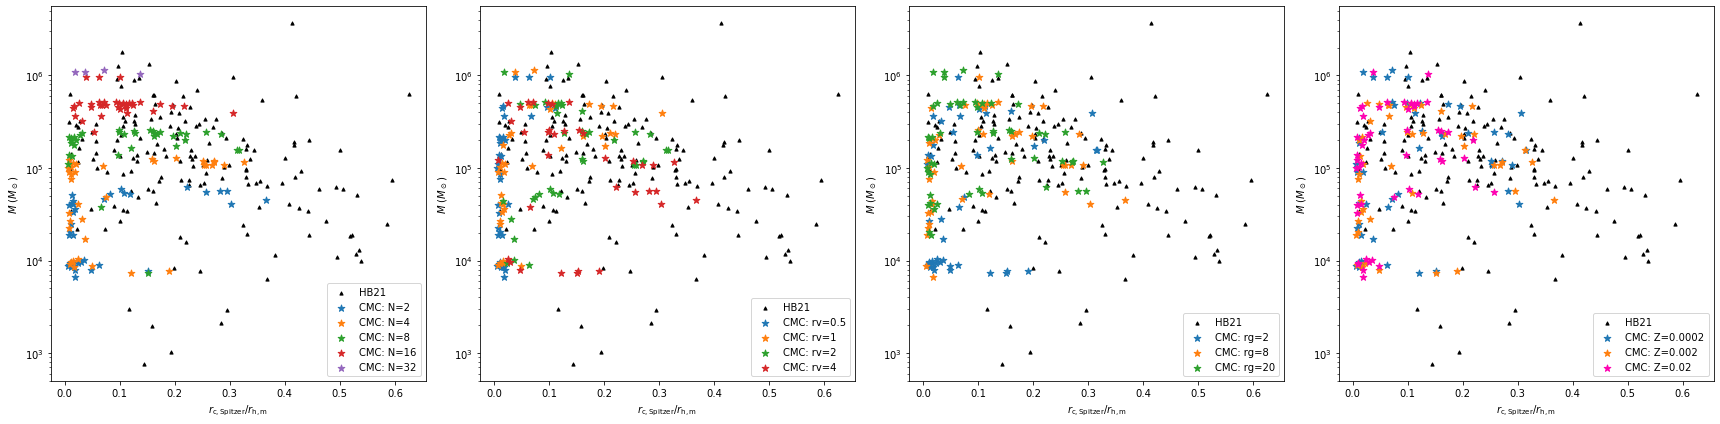

In [111]:
spaces = [
#     "Mass-rc",
#     "Mass-rh,m",
    "Mass-rc/rh,m",
#     "rh,m-rc",
]
mw_to_cmc = {
    "Mass" : "M",
    "rc" : "rc_spitzer",
    "rh,m" : "r_h",
    "rc/rh,m" : "rc_spitzer/r_h"
}
mw_to_label = {
    "Mass" : r"$M~(M_\odot)$",
    "rc" : r"$r_{\rm c, Spitzer}~(pc)$",
    "rh,m" : r"$r_{\rm h,m}~(pc)$",
    "rc/rh,m" : r"$r_{\rm c, Spitzer}/r_{\rm h,m}$",  
}
params = [
    "N",
    "rv",
    "rg",
    "Z",
]
mosaic = ["_".join((s,p)) for s in spaces for p in params]
shape = np.array([len(spaces), len(params)])
mosaic = np.reshape(mosaic, shape)
# print(mosaic)
# print(df_mw[df_mw["rc/rh,m"]>0.4])

fig, axd = plt.subplot_mosaic(
    mosaic,
    figsize=6*shape[::-1],
)
for k, ax in axd.items():
    s, p = k.split("_")
    sy,sx = s.split("-")
    scy = mw_to_cmc[sy]
    scx = mw_to_cmc[sx]
    ax.scatter(
        df_mw[sx],
        df_mw[sy],
        label="HB21", # (rc/rh<=0.4)",
        marker="^",
        s=10,
        color="k",
    )
#     ax.scatter(
#         df_mw[df_mw["rc/rh,m"]>0.4][sx],
#         df_mw[df_mw["rc/rh,m"]>0.4][sy],
#         label="HB21 (rc/rh>0.4)",
#         marker="^",
#         s=10,
#         color="r",
#     )
    
    if p == None:
        ax.scatter(
            df_cmc[scx],
            df_cmc[scy],
            label="CMC",
        )
#     elif p == "N":
#         for x in df_cmc.iloc[:,0].unique():
#             df = df_cmc[df_cmc.iloc[:,0] == x]
#             ax.scatter(
#                 df[scx],
#                 df[scy],
#                 label="CMC: %s=%g" % (p,x),
#             )        
    else:
        for x in df_cmc[p].unique():
            df = df_cmc[df_cmc[p] == x]
            if x == 0.02:
                ax.scatter(
                    df[scx],
                    df[scy],
                    label="CMC: %s=%g" % (p,x),
                    marker="*",
                    color="xkcd:bright pink",
                    s=50,
                )
            else:
                ax.scatter(
                    df[scx],
                    df[scy],
                    label="CMC: %s=%g" % (p,x),
                    marker="*",
                    s=50,
                )
    ax.set_xlabel(mw_to_label[sx])
    ax.set_ylabel(mw_to_label[sy])
    if sx != "rc/rh,m":
        ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend(loc="lower right")
plt.tight_layout()

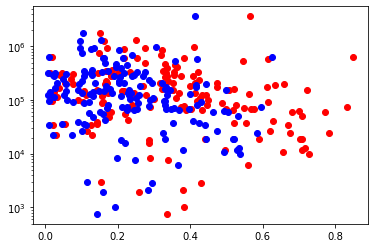

In [17]:
plt.scatter(
    df_mw["rc/rh,l"],
    df_mw["Mass"],
    color="r",
)
plt.scatter(
    df_mw["rc/rh,m"],
    df_mw["Mass"],
    color="b",
)
plt.yscale("log")

N2e5_rv0.5_rg2_Z0.0002 (1/148)...
N4e5_rv0.5_rg2_Z0.0002 (2/148)...
N8e5_rv0.5_rg2_Z0.0002 (3/148)...
N1.6e6_rv0.5_rg2_Z0.0002 (4/148)...
N2e5_rv0.5_rg2_Z0.002 (5/148)...
N4e5_rv0.5_rg2_Z0.002 (6/148)...
N8e5_rv0.5_rg2_Z0.002 (7/148)...
N1.6e6_rv0.5_rg2_Z0.002 (8/148)...
N2e5_rv0.5_rg2_Z0.02 (9/148)...
N4e5_rv0.5_rg2_Z0.02 (10/148)...
N8e5_rv0.5_rg2_Z0.02 (11/148)...
N1.6e6_rv0.5_rg2_Z0.02 (12/148)...
N2e5_rv0.5_rg8_Z0.0002 (13/148)...
N4e5_rv0.5_rg8_Z0.0002 (14/148)...
N8e5_rv0.5_rg8_Z0.0002 (15/148)...
N1.6e6_rv0.5_rg8_Z0.0002 (16/148)...
N2e5_rv0.5_rg8_Z0.002 (17/148)...
N4e5_rv0.5_rg8_Z0.002 (18/148)...
N8e5_rv0.5_rg8_Z0.002 (19/148)...
N1.6e6_rv0.5_rg8_Z0.002 (20/148)...
N2e5_rv0.5_rg8_Z0.02 (21/148)...
N4e5_rv0.5_rg8_Z0.02 (22/148)...
N8e5_rv0.5_rg8_Z0.02 (23/148)...
N1.6e6_rv0.5_rg8_Z0.02 (24/148)...
N2e5_rv0.5_rg20_Z0.0002 (25/148)...
N4e5_rv0.5_rg20_Z0.0002 (26/148)...
N8e5_rv0.5_rg20_Z0.0002 (27/148)...
N1.6e6_rv0.5_rg20_Z0.0002 (28/148)...
N2e5_rv0.5_rg20_Z0.002 (29/148)...


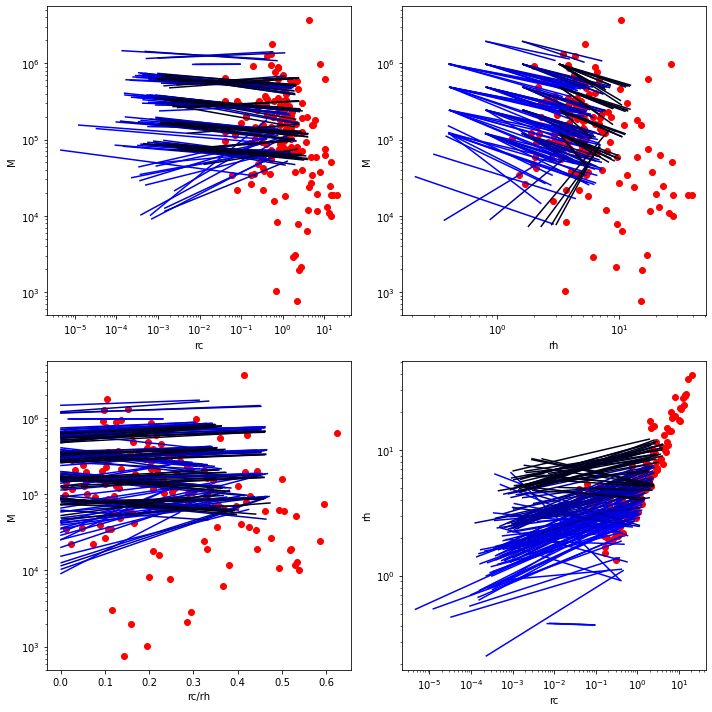

In [15]:
# Make plot grid, a la Kremer20+ Fig 2
fig, axd = plt.subplot_mosaic(
    [["M_rc", "M_rh"],
    ["M_rc/rh", "rh_rc"]],
    figsize=(10,10),
)
for k, ax in axd.items():
    ly, lx = k.split("_")
    ax.set_xlabel(lx)
    ax.set_ylabel(ly)
    if k != "M_rc/rh":
        ax.set_xscale("log")
    ax.set_yscale("log")

# Load CMC catalog
catalog_models = pd.read_csv(
    "Catalog_models.dat",
    names=["Index", "N", "rv", "rg", "Z", "N_BH", "status"],
    skiprows=2,
    delimiter=" ",
)
catalog_models.drop(columns="Index", inplace=True)

# Load final dyn_dat info for timestep
clip = 148
for mi, model in catalog_models.iterrows():
    if mi > clip-1:
        continue
    
    cmc_cluster = (
        "N{}_".format(hvss.ns_to_str(model["N"] * 100000))
        + "rv{:n}_".format(model["rv"])
        + "rg{:n}_".format(model["rg"])
        + "Z{}".format(model["Z"])
    )
    print("{} ({}/{})...".format(cmc_cluster, mi+1, len(catalog_models)))

    # Read saved data file
    path = "/hildafs/projects/phy200025p/share/catalog_files/{}.tar.gz/initial.dyn.dat".format(cmc_cluster)
#     try:
#         df_dd = cmc.load_dyn_dat(
#             path,
#         )
#     except:
#         # Look for "v2" cluster instead; if this doesn't work, let it fail
#         path = path.replace("rv", "v2_rv")
#         df_dd = cmc.load_dyn_dat(
#             path,
#         )
        
#     df_dd.drop(
#         index=range(df_dd.shape[0]-1),
#         inplace=True,
#     )

    # This counts the number of lines in the file, so we can choose to load the last one and not run out of RAM
    line = 0
    chksz = 10000
    try:
        for chunk in pd.read_csv(
            path,
            chunksize=chksz,
            index_col=0,
            usecols=[0],
        ):
            line += chunk.shape[0]
    except:
        path = path.replace("rv", "v2_rv")
        for chunk in pd.read_csv(
            path,
            chunksize=chksz,
            index_col=0,
            usecols=[0],
        ):
            line += chunk.shape[0]

    # Read the second line to get headers
    # Find the lines with the maximum and minimum radii and save mass and radius
    hi = 1 # header index
    xmin = {}
    xmax = {}
    ymin = {}
    ymax = {}
    for k in axd.keys():
        xmin[k] = np.inf
        xmax[k] = 0
        ymin[k] = np.inf
        ymax[k] = 0
    with open(path) as file:
        for li, l in enumerate(file):
            if li == hi:
                # Process columns, stripping numbers
                # "." split is necessary because of inconsistency in headers
                # "\n" strip applied to last label
                cols = [s.split(":")[-1].split(".")[-1] for s in l.split(" ")]
                cols[-1] = cols[-1].strip("\n")
                rci = cols.index("rc_spitzer")
#                 rci = cols.index("rc_nb")
                rhi = cols.index("r_h")
                mi = cols.index("M")
            elif li > hi:
                data = [float(s) for s in l.split(" ")]
                xtemp = {
                    "M_rc" : data[rci],
                    "M_rh" : data[rhi],
                    "M_rc/rh" : data[rci]/data[rhi],
                    "rh_rc" : data[rci],
                }
                ytemp = {
                    "M_rc" : data[mi],
                    "M_rh" : data[mi],
                    "M_rc/rh" : data[mi],
                    "rh_rc" : data[rhi],
                }
                for k in axd.keys():
                    if xtemp[k] < xmin[k]:
                        xmin[k] = xtemp[k]
                        ymin[k] = ytemp[k]
                    if xtemp[k] > xmax[k]:
                        xmax[k] = xtemp[k]
                        ymax[k] = ytemp[k]
    
    # Convert units
    units = cmc.get_unitdict(path.replace("dyn.dat", "conv.sh"))
    xmin["M_rc"] *= units["pc"]
    xmax["M_rc"] *= units["pc"]
    ymin["M_rc"] *= units["msun"]
    ymax["M_rc"] *= units["msun"]
    xmin["M_rh"] *= units["pc"]
    xmax["M_rh"] *= units["pc"]
    ymin["M_rh"] *= units["msun"]
    ymax["M_rh"] *= units["msun"]
    ymin["M_rc/rh"] *= units["msun"]
    ymax["M_rc/rh"] *= units["msun"]
    xmin["rh_rc"] *= units["pc"]
    xmax["rh_rc"] *= units["pc"]
    ymin["rh_rc"] *= units["pc"]
    ymax["rh_rc"] *= units["pc"]
    
    for k, ax in axd.items():
        ax.plot(
            (xmin[k], xmax[k]),
            (ymin[k], ymax[k]),
            color=(0,0,1-(model["rv"]-0.5)/4),
        )
        
axd["M_rc"].scatter(
    df_mw["rc"],
    df_mw["Mass"],
    color="r",
)
axd["M_rh"].scatter(
    df_mw["rh,m"],
    df_mw["Mass"],
    color="r",
)
axd["M_rc/rh"].scatter(
    df_mw["rc/rh,m"],
    df_mw["Mass"],
    color="r",
)
axd["rh_rc"].scatter(
    df_mw["rc"],
    df_mw["rh,m"],
    color="r",
)
plt.tight_layout()
plt.show()
    